In [8]:
import gluoncv as gcv
import mxnet as mx
import matplotlib.pyplot as plt

In [2]:
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_filepath = 'dog.jpg'
im_fname=gcv.utils.download(url=image_url,path=image_filepath)

100%|██████████| 160/160 [00:00<00:00, 428.54KB/s]


In [3]:
#  this loads the image is a multi dimensional array called an ND array. MXNet ND array is very similar to NumPy ND arrays.
image = mx.image.imread(im_fname)
# This in HWC layout as Height, Weight, Channel
print('shape', image.shape)
# After loading an image with imread, all values will be unsigned 8-bit integers.
print('data type: ', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape (576, 768, 3)
data type:  <class 'numpy.uint8'>
minimum value: 0
maximum value: 255


## Visualize the image
> We can visualize the image using pyplot.
But we first need to convert the image from an MXNet ND array to a NumPy ND array with as NumPy. 

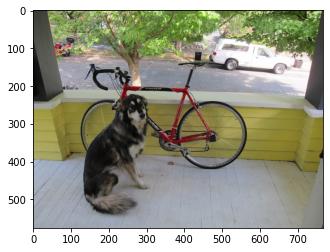

In [4]:
plt.imshow(image.asnumpy())
plt.show()

## Predict the image classification
* The network expects an input with four dimensions. It expects NCHW instead of HWC. N for the batch dimension, C for channel, H for height, and W for width.
* The neural network will expect 32-bit floats. And instead of values ranging from 0 to 255, our value should have an average value of 0 and a standard deviation of 1.
* GluonCV has a transform function to do all of this in a single step. Since we'll be using a neural network that was pre-trained on imagenet, we'll use the imagenet.transform_eval function. Other data sets have different transform functions.

### Transform and batch image

We need to create a custom transform function as there is no a preset transforms for the data set or the model that we are planning to use. With `mxnet.gluon`, it's easy to do. We can compose multiple transforms into a single transform function called `transform_fn`. We using two transforms here, `ToTensor` and `normalize`, and they're applied one after another. Using `ToTensor`, the data layer of the image will be converted from HWC to CHW. The datatype will be converted from an  8-bit integer to a 32-bit float. The method called normalize will normalize the values of the image using the ImageNet-1K statistics. We can apply the transform function just like a regular function. Calling transform_fn with the image, our output has all of the expected properties. 

In [12]:

from mxnet.gluon.data.vision import transforms

transform_fn = transforms.Compose([
    transforms.ToTensor(),
    # [.485, .456, .406] are the averages and [.229, .224, .225] are the standard deviations across RGB channels in imagenet1k dataset.
    transforms.Normalize([.485,.456,.406],[.229,.224,.225])
])


In [13]:
image = transform_fn(image)
print('shape', image.shape)
print('data type: ', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

shape (3, 576, 768)
data type:  <class 'numpy.float32'>
minimum value: -2.117904
maximum value: 2.64


### Batch Image

One final step is to create a batch from a single image. We didn't need to do this in previous lessons because the dataset and the modal transform presets handled this for us. 

It's easy to do by hand though, we just need to add an extra dimension to the beginning of our image using the `expand_dims` method. `(0)` indicates that the new dimension will be added as the first dimension.

In [14]:
image = image.expand_dims(0)
print(image.shape)

(1, 3, 576, 768)


You can see the effect of this by looking at the new image shape. You should notice the size of the first dimension is one. Then we have three channels and a height width of 567 and 768.

### Load the Model

We can use the `get_model` function to load our pretrained model from the `gluoncv.model_zoo`. We'll use the FCN network with a resonant 50 backbone that's been trained on the ADE20K data set. Our network parameters are 136 megabytes and are stored in the .mxnet cache. 

In [15]:
network = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True)

57418KB [00:29, 1968.12KB/s]                           
128832KB [00:54, 2354.58KB/s]                            


### Make Predictions

We're now ready to make a prediction. You can call `network` just like a function once again. You have network in image and a prediction will be returned.

Output is a single `mxnet.ndarray` this time, unlike for the object detection when we have a tuple of three ndarrays. Our output is a batch of predictions. Since we only had one input image, let's just slice off the batch dimension and take the first and only prediction.

In [17]:
output = network.demo(image)
print(output.shape)

(1, 150, 576, 768)


In [18]:
output = output[0]
print(output.shape)

(150, 576, 768)



Now, we're left with the prediction that has a shape of 150 by 576 by 768, and a data layout of CHW.

We have 150 channels because there are 150 classes in the ADE20K data set that was used for pretraining this model. You should recognize the last two numbers because they correspond to our images height and width.

All of the values in this array are logits, so we still need to process the outputs to obtain probabilities. We don't want to apply the softmax to all of these values at once though. We want to do this independently for all pixels so that each pixel has
a predicted probability distribution across classes.

### Closer Look: Pixel Slice

Will now try to determine the class for random pixels from the image. With our coordinate origin at the top left of the image, let's choose a pixel with the position of 300 along the vertical axis and 500 along the horizontal axis.

In [19]:
px_height, px_width = 300, 500

Since the output was in CHW format, we can slice using the colon notation at the start to keep all of the output channels for this particular pixel.

In [20]:
px_logit = output[:, px_height, px_width]

As mentioned previously, our outputs are currently logits. We can use the softmax function to convert the logits to probabilities, and after rounding the results for convenience we can see the probability distribution across classes for this particular pixel. One of the highest probabilities is towards the end with a probability of 96 percent.

In [21]:
px_probability = mx.nd.softmax(px_logit)
px_rounded_probability = mx.nd.round(px_probability*100)/100
print(px_rounded_probability)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>


Using the argmax function we can find the most likely class for this pixel.

In [22]:
class_index = mx.nd.argmax(px_logit, axis=0)
class_index = class_index[0].astype('int').asscalar()
print(class_index)

127


 After converting from an mxnet float to a Python integer, we can say that the class 127 is the most likely.

we need a lookup table from class indexes to class labels. You can usually find a lookup table on the classes property of a pretrained network, but it's also possible to use the data set directly for this. We import the ADE20K segmentation date set class and use the classes property to find the corresponding class label for our pixel prediction.

In [24]:
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation

class_label = ADE20KSegmentation.CLASSES[class_index]
print(class_label)

bicycle, bike, wheel, cycle


We find that the most likely class for the selected pixel is bike. We know our image contains a bike near the center. So this seems like a reasonable prediction.


We can perform the same analysis for all pixels at once with a minor change in how we use `softmax`. We've previously been applying softmax across all values. But by specifying `axis` equals `0`, we can apply softmax independently for all pixels. Axis zero corresponds to the channel dimension which are the classes. So the output is a probability distribution across classes for every pixel.

In [25]:
output_proba = mx.nd.softmax(output, axis=0)

Although we can't easily visualize an image with a 150 channels, we can take a slice across channels this time. Sticking with our predicted classroom before, we can slice the 127th channel and obtain an image with the probabilities of each pixel being a bike. We have an obvious cluster of pixels with a very high probability of being a bike. We can see the outline of the bike wheel and the bike frame. 

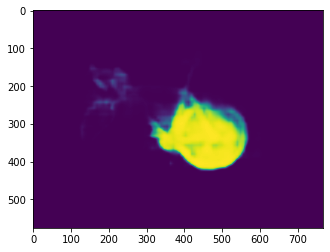

In [26]:
output_heatmap = output_proba[127]
plt.imshow(output_heatmap.asnumpy())

### Visualize most likely classes

We could do the same thing for each class, but with 150 classes, this can be a little overwhelming. A much more useful visualization is to take the most likely class for every pixel. We can use argmax just like before.

In [27]:
prediction = mx.nd.argmax(output, 0).asnumpy()
print(prediction.shape)

(576, 768)


Our prediction is now a single-channel array with the same height and width, but where all pixel values are class indexes.

We could visualize this array directly, but we'd be limited to gray scale colors, and the contrast between classes could be limited. We can instead map each class to a different color in the RGB space, and there are preset mappings for the VOC and ADE20K data sets.

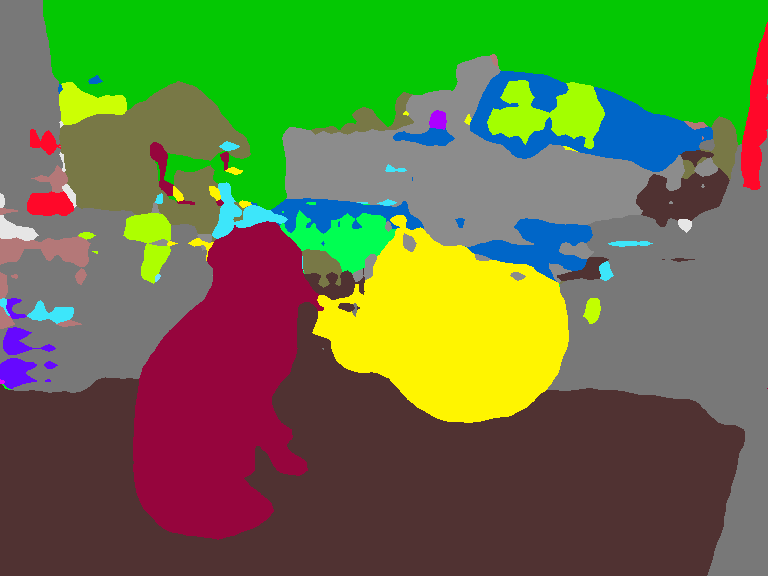

In [28]:
from gluoncv.utils.viz import get_color_pallete

prediction_image = get_color_pallete(prediction, 'ade20k')
prediction_image

Using this mapping, we can clearly see the different segments from our original image. Yellow is used to show regions where the classification is bike for example.